# **Clasificación de Dígitos Manuscritos (MNIST)** 

El conjunto de datos **MNIST** constituye un referente clásico en el aprendizaje profundo, utilizado para evaluar la capacidad de los modelos en el reconocimiento de patrones visuales.
Cada muestra corresponde a una imagen en escala de grises de **28×28 píxeles**, representando un dígito del 0 al 9.

En este proyecto se entrena una **red neuronal multicapa (FNN)** desarrollada desde cero, con el propósito de aprender a identificar correctamente los dígitos manuscritos a partir de sus características visuales.
El modelo implementa una arquitectura densa con activaciones **ReLU** y regularización mediante **Dropout**, optimizada con **Adam** y entrenada sobre **mini-lotes**. Además, incorpora técnicas de **early stopping** y un **scheduler** de tasa de aprendizaje basado en cosine annealing para mejorar la convergencia.

El objetivo final es evaluar la capacidad del modelo para **generalizar correctamente** sobre datos no vistos, analizando su rendimiento a través de métricas de precisión, curvas de aprendizaje y la matriz de confusión.

---

### **1. Cargar las librerías**

En este primer paso se importan las librerías esenciales para el desarrollo del modelo.
Se utilizan **NumPy** para el manejo de matrices y vectores, **Matplotlib** para la visualización de resultados, y los módulos personalizados del proyecto —como layers, network, losses y optimizers— que contienen las implementaciones de las capas densas, funciones de activación, algoritmo de retropropagación, y optimizadores.
Esto permite construir y entrenar una red neuronal desde cero, sin depender de frameworks externos como TensorFlow o PyTorch

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), ".."))

from src.utils import load_mnist, one_hot, train_val_test_split, accuracy, confusion_matrix
from src.layers import Dense, ReLU, Dropout
from src.losses import CrossEntropyLoss
from src.network import NeuralNetwork, Trainer, cosine_annealing
from src.optimizers import Adam

### **2. Cargar y preparar los datos**

En esta sección se cargan los datos del conjunto **MNIST**, que contiene imágenes de dígitos manuscritos del 0 al 9, y se dividen en subconjuntos de entrenamiento, validación y prueba.
Cada imagen se aplana en un vector de 784 características (28×28 píxeles) y sus etiquetas se codifican en formato one-hot para la clasificación multiclase.
Además, se crean las carpetas necesarias para almacenar los resultados del experimento.
Este paso garantiza que los datos estén listos para alimentar el modelo de forma eficiente y reproducible.

In [2]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR  = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

mnist_dir = os.path.join(PROJECT_ROOT, "data", "mnist")
(Xtr_full, ytr_full), (Xte, yte) = load_mnist(mnist_dir)

print(f"Train set: {Xtr_full.shape}, Test set: {Xte.shape}")

(Xtr, ytr), (Xva, yva), (Xte2, yte2) = train_val_test_split(
    np.vstack((Xtr_full, Xte)),
    np.hstack((ytr_full,  yte)),
    train_size=0.8, val_size=0.1, test_size=0.1, seed=42, shuffle=True
)

ytr  = one_hot(ytr)
yva  = one_hot(yva)
yte2 = one_hot(yte2)

print(f"Train: {Xtr.shape}, Val: {Xva.shape}, Test: {Xte2.shape}")

Train set: (60000, 784), Test set: (10000, 784)
Train: (56000, 784), Val: (7000, 784), Test: (7000, 784)


Tras la división en subconjuntos:

- **Conjunto de entrenamiento:** 56 000 muestras  
- **Conjunto de validación:** 7 000 muestras  
- **Conjunto de prueba:** 7 000 muestras  

Esta partición (80 % / 10 % / 10 %) garantiza una evaluación equilibrada del rendimiento del modelo y permite aplicar *early stopping* de forma efectiva.

### **3. Definir la arquitectura de la red**

Aquí se define la estructura de la red neuronal multicapa (FNN).
La arquitectura empleada consta de:

- Una capa de entrada de 784 neuronas (una por píxel).
- Dos capas ocultas con 256 y 128 neuronas respectivamente, activadas con **ReLU** e inicializadas con los métodos *He y Xavier* para mejorar la estabilidad del entrenamiento.
- Una capa de salida con 10 neuronas (una por clase).

Se añade además **Dropout (0.2)** como técnica de regularización para reducir el sobreajuste.
El optimizador utilizado es **Adam**, con tasa de aprendizaje base 1e-3, y la función de pérdida es **CrossEntropyLoss**, adecuada para problemas de clasificación multiclase.

In [3]:
np.random.seed(42)

net = NeuralNetwork([
    Dense(784, 256, init="he"), ReLU(),
    Dense(256, 128, init="he"), ReLU(),
    Dropout(0.2),
    Dense(128, 10, init="xavier")
])

opt  = Adam(lr=1e-3)
loss = CrossEntropyLoss()

### **4. Entrenamiento del modelo**

En esta fase se entrena la red neuronal con los datos preparados.
El proceso de entrenamiento incluye mecanismos de **early stopping** para detener el aprendizaje cuando la pérdida de validación deja de mejorar, evitando así el sobreajuste.
También se utiliza un **scheduler de tasa de aprendizaje** basado en cosine annealing, que reduce progresivamente la tasa para estabilizar la convergencia.

In [4]:
trainer = Trainer(
    net, opt, loss,
    early_stopping=True,
    patience=10,
    lr_scheduler=cosine_annealing,
    base_lr=1e-3,
    verbose=True
)

hist = trainer.train(
    Xtr, ytr, Xva, yva,
    epochs=50,
    batch_size=64
)

Epoch 001 | train_loss=0.2695 val_loss=0.1342 train_acc=0.920 val_acc=0.957
Epoch 002 | train_loss=0.1104 val_loss=0.0963 train_acc=0.966 val_acc=0.971
Epoch 003 | train_loss=0.0737 val_loss=0.0905 train_acc=0.977 val_acc=0.972
Epoch 004 | train_loss=0.0534 val_loss=0.0822 train_acc=0.983 val_acc=0.975
Epoch 005 | train_loss=0.0415 val_loss=0.0753 train_acc=0.987 val_acc=0.978
Epoch 006 | train_loss=0.0321 val_loss=0.0732 train_acc=0.989 val_acc=0.978
Epoch 007 | train_loss=0.0260 val_loss=0.0947 train_acc=0.991 val_acc=0.973
Epoch 008 | train_loss=0.0221 val_loss=0.0807 train_acc=0.993 val_acc=0.979
Epoch 009 | train_loss=0.0208 val_loss=0.0821 train_acc=0.993 val_acc=0.977
Epoch 010 | train_loss=0.0160 val_loss=0.0805 train_acc=0.995 val_acc=0.982
Epoch 011 | train_loss=0.0133 val_loss=0.0887 train_acc=0.996 val_acc=0.979
Epoch 012 | train_loss=0.0138 val_loss=0.0825 train_acc=0.995 val_acc=0.979
Epoch 013 | train_loss=0.0112 val_loss=0.0975 train_acc=0.996 val_acc=0.980
Epoch 014 | 

Tras 16 épocas, el entrenamiento se detiene automáticamente con una **precisión de entrenamiento del 99.7%** y una **precisión de validación del 98.3%**, mostrando una excelente capacidad de generalización.

### **5. Visualización de la Curva de Pérdida y de Precisión**

En este apartado se representan las curvas de pérdida *(loss)* y precisión *(accuracy)* durante las épocas de entrenamiento y validación.

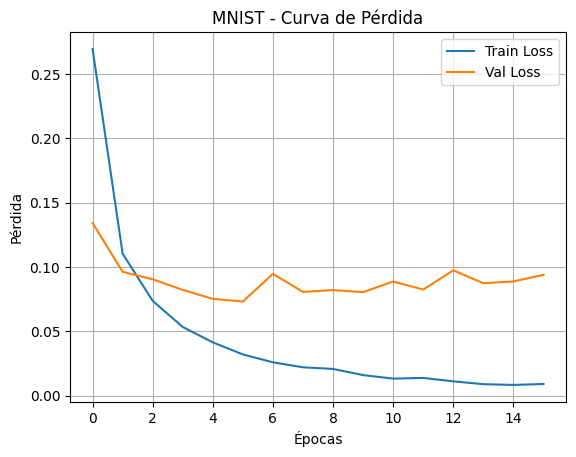

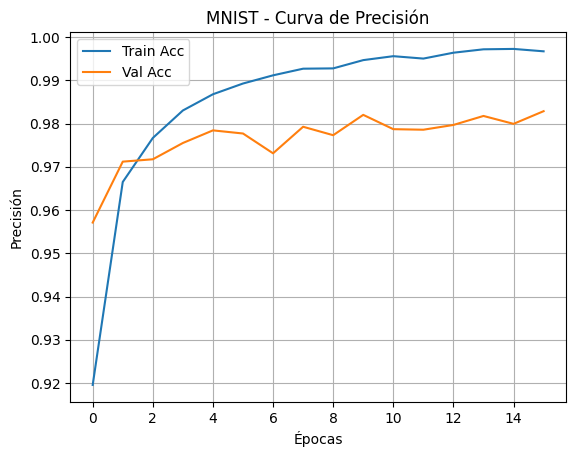

In [5]:
plt.figure()
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"],   label="Val Loss")
plt.xlabel("Épocas"); plt.ylabel("Pérdida")
plt.title("MNIST - Curva de Pérdida")
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR, "mnist_loss.png"), dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"],   label="Val Acc")
plt.xlabel("Épocas"); plt.ylabel("Precisión")
plt.title("MNIST - Curva de Precisión")
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR, "mnist_acc.png"), dpi=150, bbox_inches="tight")
plt.show()

Las gráficas muestran una disminución rápida de la pérdida en las primeras iteraciones y una estabilización posterior, mientras que la precisión alcanza valores cercanos al 99%.

La cercanía entre las curvas de entrenamiento y validación indica un modelo bien ajustado, sin signos de sobreentrenamiento significativo.

### **6. Evaluación Final**

Una vez entrenado el modelo, se evalúa su rendimiento sobre el conjunto de prueba para medir su capacidad de generalización.

In [6]:
logits_tr = net.forward(Xtr,  training=False)
logits_te = net.forward(Xte2, training=False)

train_acc = accuracy(logits_tr, np.argmax(ytr,  axis=1))
test_acc  = accuracy(logits_te, np.argmax(yte2, axis=1))

print("\nResultados finales:")
print(f"Train acc: {train_acc:.4f}")
print(f"Test  acc: {test_acc:.4f}")


 Resultados finales:
Train acc: 0.9946
Test  acc: 0.9770


Los resultados finales obtenidos son:

- **Train accuracy:** 0.9946
- **Test accuracy:** 0.9770

Esto demuestra que el modelo mantiene un rendimiento alto fuera de los datos de entrenamiento, logrando una precisión del 97.7% en el reconocimiento de dígitos manuscritos.

### **7. Matriz de Confusión**

La matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase.

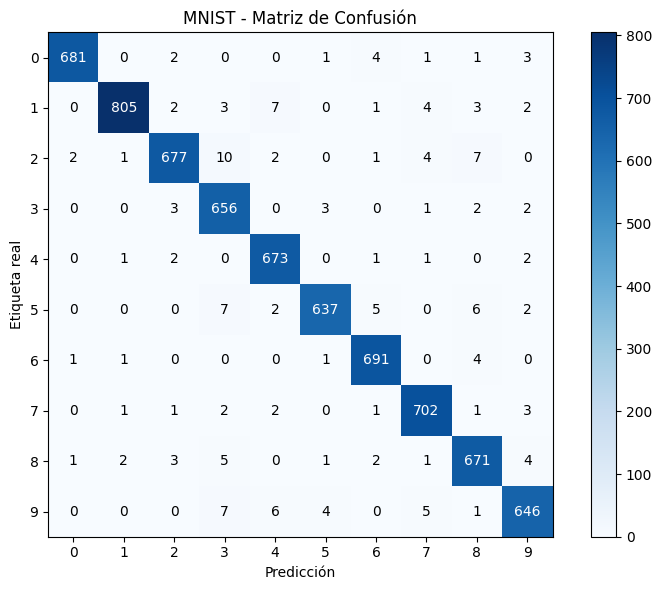

In [9]:
cm = confusion_matrix(logits_te, np.argmax(yte2, axis=1), 10)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("MNIST - Matriz de Confusión")
plt.colorbar()
ticks = np.arange(10)
plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)

th = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]}", ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "mnist_confusion.png"), dpi=150, bbox_inches="tight")
plt.show()

Se observa una fuerte diagonal dominante, lo que significa que la mayoría de las imágenes fueron clasificadas correctamente.

Los pocos errores se concentran en dígitos de forma similar, como el 1 y el 7, o el 4 y el 9, lo cual es común en este dataset.

En general, la matriz confirma la alta capacidad discriminativa del modelo entrenado.

### **8. Muestra de predicciones**
Finalmente, se visualizan ejemplos aleatorios del conjunto de prueba junto con sus etiquetas reales y las predicciones del modelo.
Las predicciones correctas se muestran en **verde**, y las incorrectas en **rojo**.


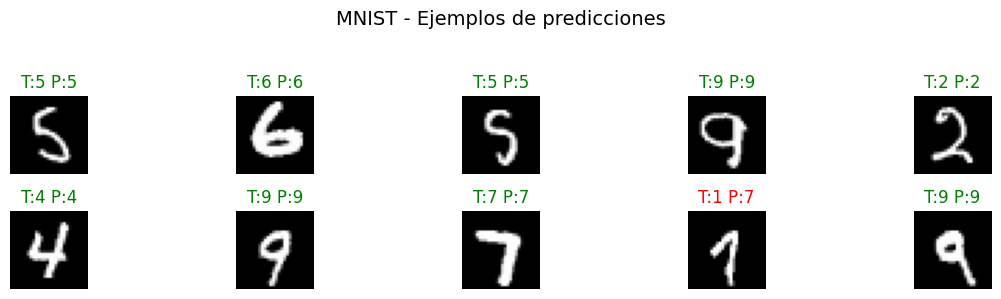

In [8]:
def visualize_predictions(net, X, y_onehot, num_samples=10):
    idx = np.random.choice(len(X), num_samples, replace=False)
    Xb, yb = X[idx], y_onehot[idx]
    
    logits = net.forward(Xb, training=False)
    y_pred = np.argmax(logits, axis=1)
    y_true = np.argmax(yb, axis=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(Xb[i].reshape(28, 28), cmap="gray")
        color = "green" if y_pred[i] == y_true[i] else "red"
        plt.title(f"T:{y_true[i]} P:{y_pred[i]}", color=color)
        plt.axis("off")

    plt.suptitle("MNIST - Ejemplos de predicciones", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(os.path.join(RESULTS_DIR, "mnist_samples.png"), dpi=150, bbox_inches="tight")
    plt.show()

visualize_predictions(net, Xte2, yte2)

La gran mayoría aparecen en verde, reforzando el alto rendimiento obtenido previamente.
Los pocos casos en rojo permiten identificar las instancias más ambiguas o difíciles (por ejemplo, confundir un “1” con un “7”), útiles para el análisis de errores y posibles mejoras futuras del modelo.


### **Conclusión**

El modelo desarrollado logró una clasificación precisa y estable del dataset MNIST, alcanzando una precisión del 97.7% en el conjunto de prueba.
La arquitectura multicapa propuesta, junto con técnicas como Dropout, early stopping y el ajuste progresivo de la tasa de aprendizaje, permitió un entrenamiento eficiente y sin sobreajuste.

Las curvas de pérdida y precisión reflejan una convergencia rápida y consistente, mientras que la matriz de confusión confirma que los errores se concentran en dígitos visualmente similares.
En conjunto, los resultados demuestran que la red neuronal implementada desde cero es capaz de aprender representaciones robustas y generalizar correctamente, validando la eficacia del diseño y las estrategias de optimización aplicadas.